In [1]:
from newspaper import Article
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
from tqdm import tqdm


In [2]:
# Load your dataset
df = pd.read_csv("/Users/julianp//Downloads/FakeNewsNet.csv")
df = df.dropna(subset=["news_url"]).copy()
df["article_text"] = ""

In [3]:
# Scrape function
def fetch_article(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        return article.text
    except:
        return ""

In [4]:
# Parallel scraping with loading bar
def parallel_scrape(urls, max_threads=16):
    results = [None] * len(urls)
    with ThreadPoolExecutor(max_workers=max_threads) as executor:
        future_to_index = {executor.submit(fetch_article, url): i for i, url in enumerate(urls)}
        for future in tqdm(as_completed(future_to_index), total=len(urls), desc="Scraping in parallel"):
            idx = future_to_index[future]
            try:
                results[idx] = future.result()
            except:
                results[idx] = ""
    return results

In [5]:
# Run parallel scrape
df["article_text"] = parallel_scrape(df["news_url"].tolist())

Scraping in parallel:  86%|████████▋ | 19741/22866 [22:49<02:28, 21.02it/s]  /Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
Scraping in parallel: 100%|██████████| 22866/22866 [54:32<00:00,  6.99it/s]


In [6]:

# Save result
df.to_csv("FakeNewsNet_with_content.csv", index=False)

In [7]:
import os

file_name = "FakeNewsNet_with_content.csv"
file_path = os.path.abspath(file_name)
print("📁 Full path:", file_path)

📁 Full path: /Users/julianp/Downloads/HW1 (1)/FakeNewsNet_with_content.csv


In [8]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Load cleaned content
df = pd.read_csv('/Users/julianp/Downloads/HW1 (1)/FakeNewsNet_with_content.csv')

# Download NLTK assets if needed
nltk.download("stopwords")
nltk.download("wordnet")

# Combine title and article
df["full_text"] = df["title"].fillna('') + " " + df["article_text"].fillna('')

# Clean function
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = text.split()
    cleaned = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(cleaned)

# Apply cleaning
df["clean_text"] = df["full_text"].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julianp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/julianp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


              precision    recall  f1-score   support

           0       0.82      0.72      0.77      1105
           1       0.91      0.95      0.93      3469

    accuracy                           0.89      4574
   macro avg       0.87      0.83      0.85      4574
weighted avg       0.89      0.89      0.89      4574



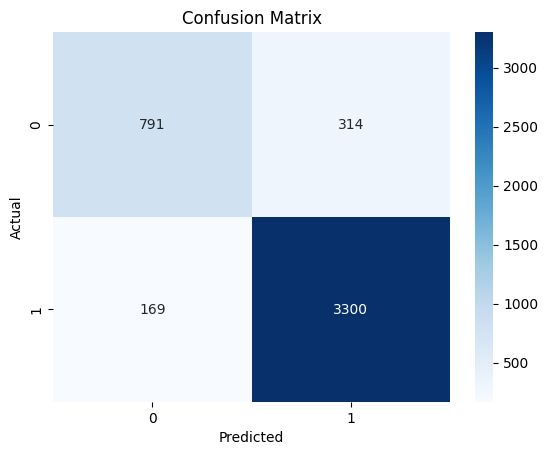

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Vectorize the cleaned text
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_text"])
y = df["real"]  # 1 = real, 0 = fake

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

######
XGBOOST

/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:45:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.70      0.74      1105
           1       0.91      0.94      0.93      3469

    accuracy                           0.88      4574
   macro avg       0.85      0.82      0.83      4574
weighted avg       0.88      0.88      0.88      4574



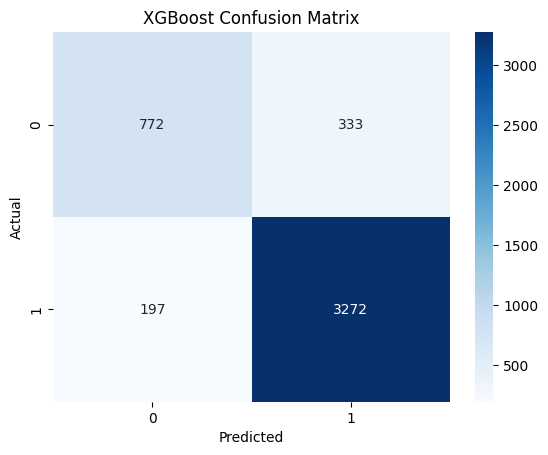

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load your cleaned dataset
df = pd.read_csv("FakeNewsNet_with_content.csv")

# Combine title + article text (if not done already)
df["full_text"] = df["title"].fillna('') + " " + df["article_text"].fillna('')

# Use pre-cleaned field if available
if "clean_text" in df.columns:
    text_data = df["clean_text"]
else:
    # Minimal fallback cleaning if needed
    import re, string
    text_data = df["full_text"].str.lower().str.replace(r"http\S+|www.\S+", "", regex=True)
    text_data = text_data.str.translate(str.maketrans("", "", string.punctuation))

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(text_data)
y = df["real"]

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()

######
RandomizedSearchCV to find best parameters
Using a 10,000 row sample to run faster
used instead of GridSearchCV as model is already performing well

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import numpy as np

# -------------------------
# Load and sample dataset
# -------------------------
df = pd.read_csv("FakeNewsNet_with_content.csv")
df = df.sample(n=10000, random_state=42)  # reduce training time
df["full_text"] = df["title"].fillna('') + " " + df["article_text"].fillna('')
text_data = df["clean_text"] if "clean_text" in df.columns else df["full_text"]

# -------------------------
# TF-IDF vectorization
# -------------------------
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(text_data)
y = df["real"]

# -------------------------
# Train/Test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------
# Base model and param grid
# -------------------------
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")

param_distributions = {
    "n_estimators": [100, 200],
    "max_depth": [4, 6],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "scale_pos_weight": [1, 2]
}

# -------------------------
# Randomized search (fast)
# -------------------------
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=10,
    scoring="f1_macro",
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=4
)

# -------------------------
# Fit and evaluate
# -------------------------
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
print("✅ Best parameters:", random_search.best_params_)

y_pred = best_model.predict(X_test)
print("📊 Classification Report (Optimized XGBoost):")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:43:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:43:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:43:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:43:29] WARNING: /Users/runner/work/xgboost/xgboost/src/lear

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.6s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:43:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:43:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:43:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:43:33] WARNING: /Users/runner/work/xgboost/xgboost/src/lear

[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.5s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:43:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.9s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:43:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:43:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:43:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   4.0s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:43:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   4.0s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:43:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   6.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   6.8s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:43:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:43:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   6.5s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:43:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   6.9s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:43:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   6.7s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:43:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   8.1s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:43:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   8.5s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:43:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   8.2s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:43:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   8.4s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:43:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   8.4s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   5.7s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   5.8s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   6.5s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   6.5s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   6.3s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   6.6s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   5.5s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   5.4s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   5.6s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.1s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   5.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.0s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   2.8s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.0s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=100, scale_pos_weight=1, subsample=0.8; total time=   3.1s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.2s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.2s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=4, n_estimators=100, scale_pos_weight=2, subsample=0.8; total time=   3.2s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   5.9s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   5.9s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   5.8s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   6.0s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=200, scale_pos_weight=1, subsample=0.8; total time=   5.9s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   8.7s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   8.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   8.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   8.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, scale_pos_weight=2, subsample=0.8; total time=   8.3s


/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:44:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best parameters: {'subsample': 0.8, 'scale_pos_weight': 1, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
📊 Classification Report (Optimized XGBoost):
              precision    recall  f1-score   support

           0       0.80      0.67      0.73       510
           1       0.89      0.94      0.92      1490

    accuracy                           0.87      2000
   macro avg       0.85      0.81      0.82      2000
weighted avg       0.87      0.87      0.87      2000



In [14]:
import joblib
joblib.dump(best_model, "xgboost_fake_news_model.joblib")
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")

['tfidf_vectorizer.joblib']

In [15]:
best_model = joblib.load("xgboost_fake_news_model.joblib")
vectorizer = joblib.load("tfidf_vectorizer.joblib")

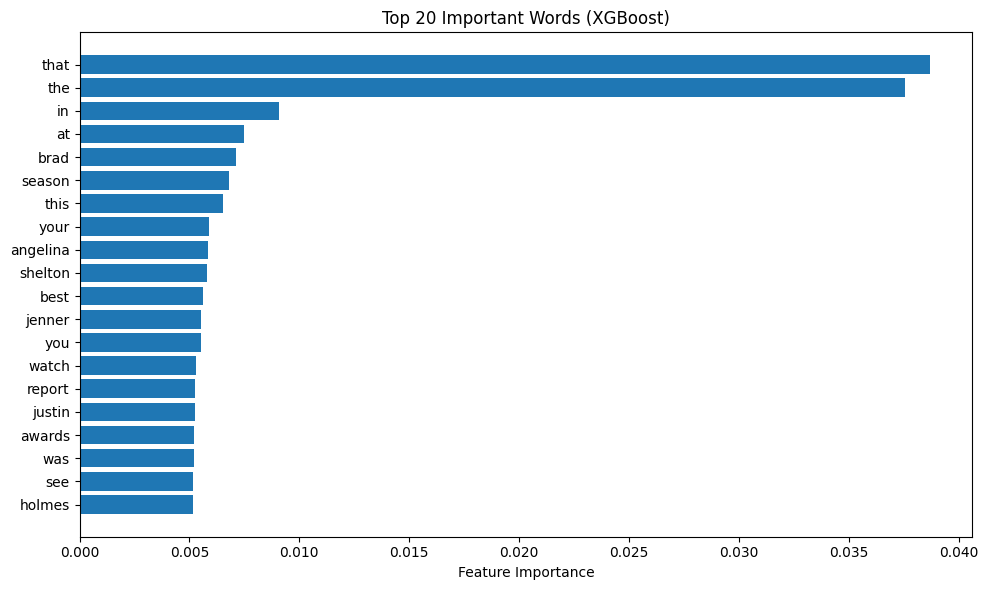

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature names from TF-IDF
feature_names = vectorizer.get_feature_names_out()

# Get feature importances from model
importances = best_model.feature_importances_

# Combine names and importances
top_n = 20
indices = np.argsort(importances)[-top_n:]  # Top N features

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), importances[indices], align="center")
plt.yticks(range(top_n), [feature_names[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 20 Important Words (XGBoost)")
plt.tight_layout()
plt.show()

####
Stop words such as "the" or "that" removed 

/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [11:26:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 Classification Report (Cleaned XGBoost):
              precision    recall  f1-score   support

           0       0.79      0.67      0.73      1105
           1       0.90      0.94      0.92      3469

    accuracy                           0.88      4574
   macro avg       0.85      0.81      0.82      4574
weighted avg       0.87      0.88      0.87      4574



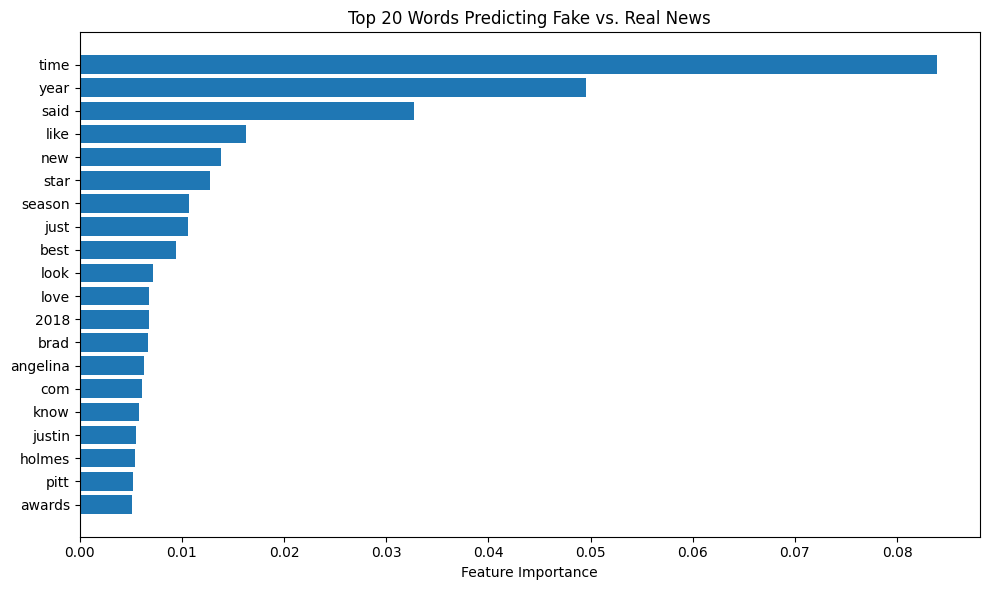

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# ------------------------
# Load dataset
# ------------------------
df = pd.read_csv("FakeNewsNet_with_content.csv")
df["full_text"] = df["title"].fillna('') + " " + df["article_text"].fillna('')
text_data = df["clean_text"] if "clean_text" in df.columns else df["full_text"]
y = df["real"]

# ------------------------
# TF-IDF vectorization (with stopwords removed)
# ------------------------
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words="english"  # removes "the", "that", "is", etc.
)
X = vectorizer.fit_transform(text_data)

# ------------------------
# Train/test split
# ------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------
# Train XGBoost with best parameters
# ------------------------
best_model = XGBClassifier(
    subsample=0.8,
    scale_pos_weight=1,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric="logloss"
)
best_model.fit(X_train, y_train)

# ------------------------
# Evaluate
# ------------------------
y_pred = best_model.predict(X_test)
print("📊 Classification Report (Cleaned XGBoost):")
print(classification_report(y_test, y_pred))

# ------------------------
# Plot feature importance
# ------------------------
importances = best_model.feature_importances_
feature_names = vectorizer.get_feature_names_out()

# Top N features
top_n = 20
indices = np.argsort(importances)[-top_n:]

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), importances[indices], align="center")
plt.yticks(range(top_n), [feature_names[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 20 Words Predicting Fake vs. Real News")
plt.tight_layout()
plt.show()

#####
changing vectorization to include bigrams (2 words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julianp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [11:40:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.07      0.12        27
           1       0.99      1.00      0.99      2550

    accuracy                           0.99      2577
   macro avg       0.70      0.54      0.56      2577
weighted avg       0.98      0.99      0.99      2577


🔥 Top 20 important features:
fbi                  0.0249
trump                0.0229
times                0.0194
personally           0.0194
company              0.0159
washington           0.0144
health               0.0131
democrat             0.0106
statement            0.0102
administration       0.0101
arrested             0.0098
issues               0.0097
love                 0.0090
donald trump         0.0089
state                0.0087
made                 0.0085
human                0.0084
president            0.0084
money                0.0082
first                0.0081


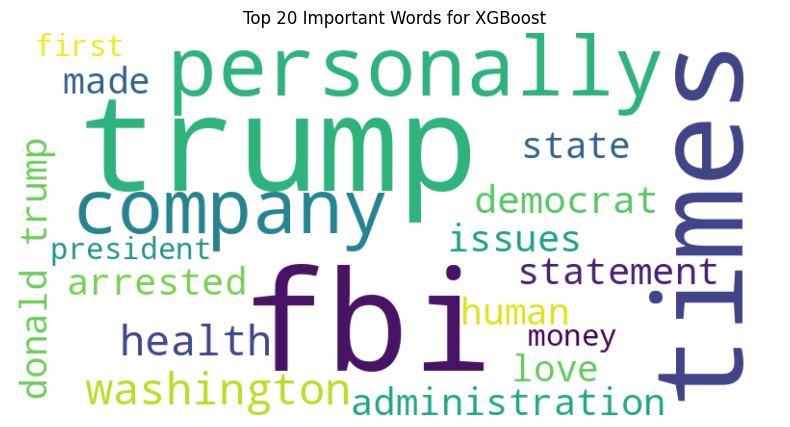

In [21]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from wordcloud import WordCloud

# Download NLTK resources
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Load dataset
df = pd.read_csv("FakeNewsNet_with_content.csv")

# Drop rows with missing text or labels
df = df.dropna(subset=['article_text', 'real'])

# Clean text function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-zA-Z]", " ", text)  # keep only letters
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words and len(w) > 2]
    return " ".join(tokens)

# Apply cleaning
df['clean_text'] = df['article_text'].apply(clean_text)

# Define features and labels
X = df['clean_text']
y = df['real']  # 1 = real, 0 = fake

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train XGBoost model with best params from earlier
model = XGBClassifier(
    learning_rate=0.1,
    max_depth=6,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=1
)
model.fit(X_train_vec, y_train)

# Evaluate
y_pred = model.predict(X_test_vec)
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
importances = model.feature_importances_
feature_names = vectorizer.get_feature_names_out()
top_idx = np.argsort(importances)[::-1][:20]
top_words = [(feature_names[i], importances[i]) for i in top_idx]

print("\n🔥 Top 20 important features:")
for word, score in top_words:
    print(f"{word:20s} {score:.4f}")

# Optional: WordCloud of top features
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies({word: score for word, score in top_words})

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top 20 Important Words for XGBoost")
plt.show()

In [22]:
print(df["real"].value_counts())

real
1    12744
0      137
Name: count, dtype: int64


Using smote to rebalance classes since webscraping decimated the dataset

/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [11:58:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 Classification Report (SMOTE XGBoost):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2548
           1       1.00      0.99      1.00      2550

    accuracy                           1.00      5098
   macro avg       1.00      1.00      1.00      5098
weighted avg       1.00      1.00      1.00      5098


🔥 Top 20 important features:
transfer             0.0694
trump                0.0441
religious            0.0244
human                0.0241
senate               0.0238
said statement       0.0208
state                0.0190
process              0.0188
jail                 0.0178
citizens             0.0166
love                 0.0148
season               0.0139
increase             0.0133
academy award        0.0118
im                   0.0116
released statement   0.0108
wedding              0.0104
percentage           0.0103
crash                0.0098
viral                0.0096


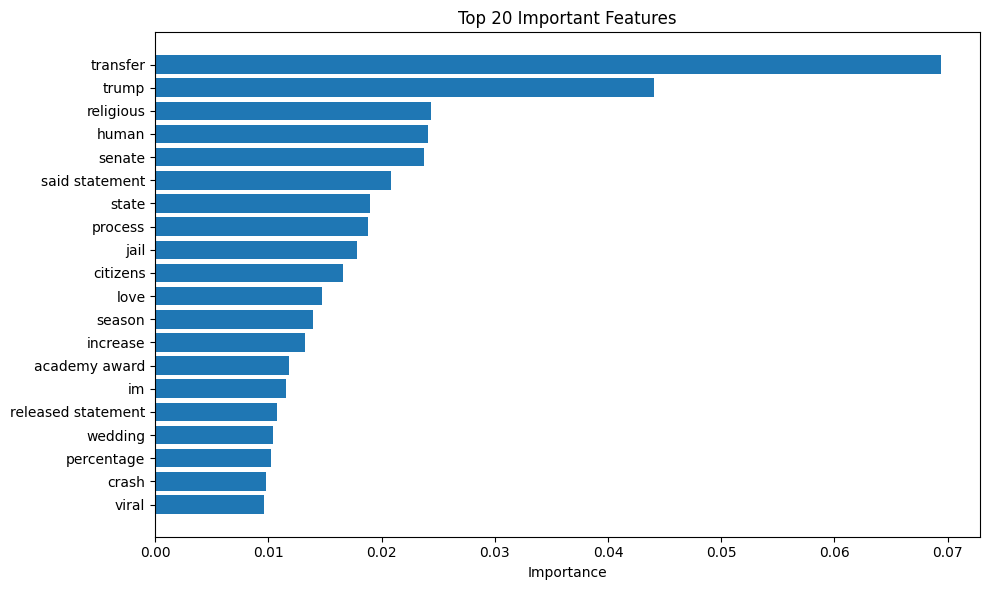

In [24]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# -----------------------------
# 1. Load the dataset
# -----------------------------
df = pd.read_csv("FakeNewsNet_with_content.csv")

# -----------------------------
# 2. Clean the dataset
# -----------------------------
df = df.dropna(subset=["article_text", "real"])
df['real'] = df['real'].astype(int)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # remove digits
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text)  # normalize whitespace
    return text.strip()

df['clean_text'] = df['article_text'].apply(clean_text)

# -----------------------------
# 3. TF-IDF Vectorization
# -----------------------------
X = df['clean_text']
y = df['real']

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_vec = vectorizer.fit_transform(X)

# -----------------------------
# 4. SMOTE Resampling
# -----------------------------
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_vec, y)

# -----------------------------
# 5. Train/Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# -----------------------------
# 6. Train XGBoost Classifier
# -----------------------------
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# -----------------------------
# 7. Evaluate Performance
# -----------------------------
y_pred = model.predict(X_test)
print("📊 Classification Report (SMOTE XGBoost):")
print(classification_report(y_test, y_pred))

# -----------------------------
# 8. Feature Importance
# -----------------------------
feature_names = vectorizer.get_feature_names_out()
importances = model.feature_importances_
top_indices = np.argsort(importances)[-20:][::-1]

print("\n🔥 Top 20 important features:")
for idx in top_indices:
    print(f"{feature_names[idx]:<20} {importances[idx]:.4f}")

# Optional: Bar plot of top features
plt.figure(figsize=(10, 6))
plt.barh([feature_names[i] for i in top_indices][::-1], importances[top_indices][::-1])
plt.xlabel("Importance")
plt.title("Top 20 Important Features")
plt.tight_layout()
plt.show()

In [25]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Make sure NLTK resources are available
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv("FakeNewsNet_with_content.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Prepare labels and features
df = df.dropna(subset=['article_text', 'real'])
df['real'] = df['real'].astype(int)
X_raw = df['article_text']
y = df['real']

# Text cleaning
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

X_cleaned = X_raw.apply(clean_text)

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_vect = tfidf.fit_transform(X_cleaned)

# XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Pipeline with SMOTE and XGBoost
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', xgb)
])

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X_vect, y, scoring='f1', cv=cv, n_jobs=-1)

print("✅ Cross-validated F1 scores:", scores)
print("📈 Mean F1 score:", np.mean(scores).round(4))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julianp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/julianp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:03:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:03:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/julianp/Downloads/HW1 (1)/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:03:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:73

✅ Cross-validated F1 scores: [0.99254902 0.99294671 0.99254317 0.99254024 0.99333856]
📈 Mean F1 score: 0.9928


In [29]:
import pandas as pd

# Load each file into a properly named variable
df_fake = pd.read_csv("/Users/julianp/Downloads/News_Dataset/Fake.csv")
df_real = pd.read_csv("/Users/julianp/Downloads/News_Dataset/True.csv")

# Assign labels
df_fake['label'] = 0
df_real['label'] = 1

# Combine both into a single dataframe
df = pd.concat([df_fake, df_real], ignore_index=True)

# Optional: shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)

# Preview
print(df['label'].value_counts())
print(df.head())

label
0    23481
1    21417
Name: count, dtype: int64
                                               title  \
0  Trump wades in on flap over L.L. Bean boycott ...   
1  McCain says Russia testing U.S. in Ukraine, ur...   
2   Hot Mic Catches Someone Saying What We All We...   
3  China angered as U.S. considers navy visits to...   
4  Facing crime wave, residents in South Sudan ca...   

                                                text       subject  \
0  BOSTON (Reuters) - Donald Trump on Thursday tw...  politicsNews   
1  WASHINGTON (Reuters) - Russia is testing Presi...  politicsNews   
2  On Tuesday, a hot mic at a House Republican pr...          News   
3  BEIJING/TAIPEI (Reuters) - China accused the U...     worldnews   
4  JUBA (Reuters) - Residents of South Sudan s ca...     worldnews   

                  date  label  
0    January 12, 2017       1  
1    February 2, 2017       1  
2     January 31, 2017      0  
3   December 14, 2017       1  
4  September 21, 2017       